In [0]:
%restart_python

In [0]:
%sql
-- USERS TABLE
CREATE TABLE IF NOT EXISTS users (
    user_id STRING NOT NULL,
    default_city STRING,
    default_state STRING,
    CONSTRAINT pk_users PRIMARY KEY (user_id)
) USING DELTA;

-- DEVICES TABLE
CREATE TABLE IF NOT EXISTS devices (
    device_id STRING NOT NULL,
    device_os STRING,
    CONSTRAINT pk_devices PRIMARY KEY (device_id)
) USING DELTA;

-- RECIPIENTS TABLE (Merchants)
CREATE TABLE IF NOT EXISTS recipients (
    merchant_id STRING NOT NULL,
    merchant_category STRING,
    CONSTRAINT pk_recipients PRIMARY KEY (merchant_id)
) USING DELTA;

-- TRANSACTIONS TABLE
CREATE TABLE IF NOT EXISTS transactions (
    transaction_id STRING NOT NULL,
    transaction_date DATE,
    transaction_time STRING,
    user_id STRING NOT NULL,
    merchant_id STRING NOT NULL,
    device_id STRING NOT NULL,
    upi_channel STRING,
    transaction_city STRING,
    transaction_state STRING,
    ip_address STRING,
    transaction_status STRING,
    amount FLOAT,
    transaction_amount_deviation FLOAT,
    fraud INT,
    CONSTRAINT pk_transactions PRIMARY KEY (transaction_id),
    CONSTRAINT fk_txn_user FOREIGN KEY (user_id) REFERENCES users(user_id),
    CONSTRAINT fk_txn_device FOREIGN KEY (device_id) REFERENCES devices(device_id),
    CONSTRAINT fk_txn_merchant FOREIGN KEY (merchant_id) REFERENCES recipients(merchant_id)
) USING DELTA;




In [0]:
from faker import Faker
from datetime import datetime, timedelta
import random
from collections import defaultdict
from pyspark.sql.types import (
    StructType, StructField, StringType, FloatType, DateType, IntegerType
)
from pyspark.sql.functions import col, hour, unix_timestamp, when, date_format

# For demonstration, using a static list:
city_state_dict = {
    "Mumbai": "Maharashtra",
    "Delhi": "Delhi",
    "Bangalore": "Karnataka",
    "Hyderabad": "Telangana",
    "Ahmedabad": "Gujarat",
    "Chennai": "Tamil Nadu",
    "Kolkata": "West Bengal",
    "Pune": "Maharashtra",
    "Jaipur": "Rajasthan",
    "Surat": "Gujarat",
    "Lucknow": "Uttar Pradesh",
    "Kanpur": "Uttar Pradesh",
    "Nagpur": "Maharashtra",
    "Indore": "Madhya Pradesh",
    "Thane": "Maharashtra",
    "Bhopal": "Madhya Pradesh",
    "Visakhapatnam": "Andhra Pradesh",
    "Pimpri-Chinchwad": "Maharashtra",
    "Patna": "Bihar",
    "Vadodara": "Gujarat",
    "Ghaziabad": "Uttar Pradesh",
    "Ludhiana": "Punjab",
    "Agra": "Uttar Pradesh",
    "Nashik": "Maharashtra",
    "Faridabad": "Haryana",
    "Meerut": "Uttar Pradesh",
    "Rajkot": "Gujarat",
    "Kalyan-Dombivli": "Maharashtra",
    "Vasai-Virar": "Maharashtra",
    "Varanasi": "Uttar Pradesh",
    "Srinagar": "Jammu and Kashmir",
    "Aurangabad": "Maharashtra",
    "Dhanbad": "Jharkhand",
    "Amritsar": "Punjab",
    "Navi Mumbai": "Maharashtra",
    "Prayagraj": "Uttar Pradesh",
    "Howrah": "West Bengal",
    "Ranchi": "Jharkhand",
    "Jabalpur": "Madhya Pradesh",
    "Gwalior": "Madhya Pradesh",
    "Coimbatore": "Tamil Nadu",
    "Vijayawada": "Andhra Pradesh",
    "Jodhpur": "Rajasthan",
    "Madurai": "Tamil Nadu",
    "Raipur": "Chhattisgarh",
    "Kota": "Rajasthan",
    "Guwahati": "Assam",
    "Chandigarh": "Chandigarh",
    "Solapur": "Maharashtra",
    "Hubli-Dharwad": "Karnataka",
    "Tiruchirappalli": "Tamil Nadu",
    "Bareilly": "Uttar Pradesh",
    "Mysore": "Karnataka",
    "Tiruppur": "Tamil Nadu",
    "Gurgaon": "Haryana",
    "Aligarh": "Uttar Pradesh",
    "Jalandhar": "Punjab",
    "Bhubaneswar": "Odisha",
    "Salem": "Tamil Nadu",
    "Mira-Bhayandar": "Maharashtra",
    "Warangal": "Telangana",
    "Thiruvananthapuram": "Kerala",
    "Guntur": "Andhra Pradesh",
    "Bhiwandi": "Maharashtra",
    "Saharanpur": "Uttar Pradesh",
    "Gorakhpur": "Uttar Pradesh",
    "Bikaner": "Rajasthan",
    "Amravati": "Maharashtra",
    "Noida": "Uttar Pradesh",
    "Jamshedpur": "Jharkhand",
    "Bhilai": "Chhattisgarh",
    "Cuttack": "Odisha",
    "Firozabad": "Uttar Pradesh",
    "Kochi": "Kerala",
    "Nellore": "Andhra Pradesh",
    "Bhavnagar": "Gujarat",
    "Dehradun": "Uttarakhand",
    "Durgapur": "West Bengal",
    "Asansol": "West Bengal",
    "Nanded": "Maharashtra",
    "Kolhapur": "Maharashtra",
    "Ajmer": "Rajasthan",
    "Gulbarga": "Karnataka",
    "Jamnagar": "Gujarat",
    "Ujjain": "Madhya Pradesh",
    "Loni": "Uttar Pradesh",
    "Siliguri": "West Bengal",
    "Jhansi": "Uttar Pradesh",
    "Ulhasnagar": "Maharashtra",
    "Jammu": "Jammu and Kashmir",
    "Sangli-Miraj & Kupwad": "Maharashtra",
    "Mangalore": "Karnataka",
    "Erode": "Tamil Nadu",
    "Belgaum": "Karnataka",
    "Ambattur": "Tamil Nadu",
    "Tirunelveli": "Tamil Nadu",
    "Malegaon": "Maharashtra",
    "Gaya": "Bihar",
    "Jalgaon": "Maharashtra",
    "Udaipur": "Rajasthan",
    "Maheshtala": "West Bengal",
    "Davanagere": "Karnataka",
    "Kozhikode": "Kerala",
    "Kurnool": "Andhra Pradesh",
    "Akola": "Maharashtra",
    "Rajpur Sonarpur": "West Bengal",
    "Rajahmundry": "Andhra Pradesh",
    "Bokaro": "Jharkhand",
    "South Dumdum": "West Bengal",
    "Bellary": "Karnataka",
    "Patiala": "Punjab",
    "Gopalpur": "Odisha",
    "Agartala": "Tripura",
    "Bhagalpur": "Bihar",
    "Muzaffarnagar": "Uttar Pradesh",
    "Bhatpara": "West Bengal",
    "Panihati": "West Bengal",
    "Latur": "Maharashtra",
    "Dhule": "Maharashtra",
    "Tirupati": "Andhra Pradesh",
    "Rohtak": "Haryana",
    "Korba": "Chhattisgarh",
    "Bhilwara": "Rajasthan",
    "Berhampur": "Odisha",
    "Muzaffarpur": "Bihar",
    "Ahmednagar": "Maharashtra",
    "Mathura": "Uttar Pradesh",
    "Kollam": "Kerala",
    "Avadi": "Tamil Nadu",
    "Kadapa": "Andhra Pradesh",
    "Kamarhati": "West Bengal",
    "Bilaspur": "Chhattisgarh",
    "Shahjahanpur": "Uttar Pradesh",
    "Bijapur": "Karnataka",
    "Rampur": "Uttar Pradesh",
    "Shivamogga": "Karnataka",
    "Chandrapur": "Maharashtra",
    "Junagadh": "Gujarat",
    "Thrissur": "Kerala",
    "Alwar": "Rajasthan",
    "Bardhaman": "West Bengal",
    "Kulti": "West Bengal",
    "Kakinada": "Andhra Pradesh",
    "Nizamabad": "Telangana",
    "Parbhani": "Maharashtra",
    "Tumkur": "Karnataka",
    "Khammam": "Telangana",
    "Ozhukarai": "Puducherry",
    "Bihar Sharif": "Bihar",
    "Panipat": "Haryana",
    "Darbhanga": "Bihar",
    "Bally": "West Bengal",
    "Aizawl": "Mizoram",
    "Dewas": "Madhya Pradesh",
    "Ichalkaranji": "Maharashtra",
    "Karnal": "Haryana",
    "Bathinda": "Punjab",
    "Jalna": "Maharashtra",
    "Eluru": "Andhra Pradesh",
    "Kirari Suleman Nagar": "Delhi",
    "Barasat": "West Bengal",
    "Purnia": "Bihar",
    "Satna": "Madhya Pradesh",
    "Mau": "Uttar Pradesh",
    "Sonipat": "Haryana",
    "Farrukhabad": "Uttar Pradesh",
    "Sagar": "Madhya Pradesh",
    "Rourkela": "Odisha",
    "Durg": "Chhattisgarh",
    "Imphal": "Manipur",
    "Ratlam": "Madhya Pradesh",
    "Hapur": "Uttar Pradesh",
    "Arrah": "Bihar",
    "Karimnagar": "Telangana",
    "Anantapur": "Andhra Pradesh",
    "Etawah": "Uttar Pradesh",
    "Ambarnath": "Maharashtra",
    "North Dumdum": "West Bengal",
    "Bharatpur": "Rajasthan",
    "Begusarai": "Bihar",
    "New Delhi": "Delhi",
    "Gandhidham": "Gujarat",
    "Baranagar": "West Bengal",
    "Tiruvottiyur": "Tamil Nadu",
    "Puducherry": "Puducherry",
    "Sikar": "Rajasthan",
    "Thoothukudi": "Tamil Nadu",
    "Rewa": "Madhya Pradesh",
    "Mirzapur": "Uttar Pradesh",
    "Raichur": "Karnataka",
    "Pali": "Rajasthan"
}
# (Paste the above dictionary here)

cities = list(city_state_dict.keys())
states = list(set(city_state_dict.values()))




fake = Faker('en_IN')
random.seed(42)
Faker.seed(42)

NUM_USERS = 2000
NUM_DEVICES = 1000
NUM_RECIPIENTS = 1500
NUM_TRANSACTIONS = 20000



transaction_statuses = ["Completed", "Pending", "Failed"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, (end - start).days))

# USERS TABLE
# Prepare the list of cities from the city_state_dict
cities = list(city_state_dict.keys())

user_rows, user_ids, user_city_map = [], [], {}
for i in range(1, NUM_USERS + 1):
    user_id = str(i)
    default_city = random.choice(cities)
    default_state = city_state_dict[default_city]

    user_rows.append((user_id, default_city, default_state))
    user_ids.append(user_id)
    # Sample 3 known cities for the user from the same city list
    user_city_map[user_id] = set(random.sample(cities, min(3, len(cities))))
user_schema = StructType([
    StructField("user_id", StringType(), False),
    StructField("default_city", StringType(), True),
    StructField("default_state", StringType(), True)
])
users_df = spark.createDataFrame(user_rows, schema=user_schema)
users_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("upi_fraud_schema.users")

# DEVICES TABLE
device_rows, device_ids, user_to_devices = [], [], defaultdict(list)
for i in range(1, NUM_DEVICES + 1):
    device_id = str(i)
    os_types = ['Android', 'iOS', 'Windows', 'Other']
    weights = [60.7, 25.0, 11.18, 1.12]
    norm_weights = [w / sum(weights) for w in weights]
    device_os = random.choices(os_types, weights=norm_weights)[0]

    user_id = random.choice(user_ids)
    device_rows.append((device_id, device_os))
    device_ids.append(device_id)
    user_to_devices[user_id].append(device_id)
device_schema = StructType([
    StructField("device_id", StringType(), False),
    StructField("device_os", StringType(), True)
])
devices_df = spark.createDataFrame(device_rows, schema=device_schema)
devices_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("upi_fraud_schema.devices")

# RECIPIENTS TABLE (Merchants)
recipient_rows, merchant_ids = [], []
for i in range(1, NUM_RECIPIENTS + 1):
    merchant_id = str(i)

    # Proper distribution for merchant categories
    merchant_categories = ['Utilities', 'Shopping', 'Food', 'Travel', 'Education', 'Healthcare']
    weights = [35, 25, 15, 10, 8, 7]
    norm_weights = [w / sum(weights) for w in weights]
    merchant_category = random.choices(merchant_categories, weights=norm_weights)[0]

    recipient_rows.append((merchant_id, merchant_category))
    merchant_ids.append(merchant_id)
recipient_schema = StructType([
    StructField("merchant_id", StringType(), False),
    StructField("merchant_category", StringType(), True)
])
recipients_df = spark.createDataFrame(recipient_rows, schema=recipient_schema)
recipients_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("upi_fraud_schema.recipients")

# TRANSACTIONS TABLE
transaction_rows = []
for i in range(1, NUM_TRANSACTIONS + 1):
    transaction_id = str(i)
    # Probabilities constraint on days 
    # Step 1: Define probabilities
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    weights = [20, 10, 9, 11,18 , 19, 13 ]
    norm_weights = [w / sum(weights) for w in weights]

    # Step 2: Pick a day of week
    chosen_day = random.choices(days, weights=norm_weights)[0]

    # Step 3: Find all dates in range that match chosen day
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2024, 6, 30)
    matching_dates = []
    current = start_date
    while current <= end_date:
        if current.strftime('%A') == chosen_day:
            matching_dates.append(current)
        current += timedelta(days=1)

    # Step 4: Pick a random date from those
    date_obj = random.choice(matching_dates)
    transaction_date = date_obj.date()

    # Step 5: Generate random time
    transaction_time = fake.time(pattern="%I:%M:%S %p")

    user_id = random.choice(user_ids)
    merchant_id = random.choice(merchant_ids)
    possible_devices = user_to_devices[user_id]
    device_id = random.choice(possible_devices) if possible_devices else random.choice(device_ids)
    # Randomise the UPI channels data  
    upi_channels = ["PhonePe", "GPay", "PayTM", "BHIM"]
    weights_upi = [0.52, 0.25, 0.15, 0.08]  # These represent the probabilities
    upi_channel = random.choices(upi_channels, weights=weights_upi)[0]

    transaction_city = random.choice(list(city_state_dict.keys()))
    transaction_state = city_state_dict[transaction_city]
    ip_address = fake.ipv4()
    transaction_status = random.choice(transaction_statuses)
    
    def get_realistic_amount(category):
        r = random.random()
        if category == "Education" or category == "Healthcare":
            if r < 0.75:
                return round(random.uniform(1000, 50000), 2)
            elif r < 0.95:
                return round(random.uniform(50001, 200000), 2)
            else:
                return round(random.uniform(200001, 500000), 2)  # Rare, high-value
        elif category == "Travel":
            if r < 0.85:
                return round(random.uniform(500, 20000), 2)
            else:
                return round(random.uniform(20001, 100000), 2)
        elif category == "Shopping":
            if r < 0.9:
                return round(random.uniform(100, 10000), 2)
            else:
                return round(random.uniform(10001, 100000), 2)
        elif category == "Utilities":
            if r < 0.95:
                return round(random.uniform(50, 2000), 2)
            else:
                return round(random.uniform(2001, 10000), 2)
        elif category == "Food":
            if r < 0.98:
                return round(random.uniform(50, 2000), 2)
            else:
                return round(random.uniform(2001, 10000), 2)
        else:
            return round(random.uniform(1, 5000), 2)
    
    amount = get_realistic_amount(merchant_category)
    transaction_amount_deviation = round(random.uniform(-100, 100), 2)
    # --- Improved Risk Score Calculation ---
    risk_score = 0

    # Category-aware high amount thresholds (add this dict at the top of your script)
    category_thresholds = {
        "Utilities": 2000,
        "Shopping": 10000,
        "Food": 2000,
        "Travel": 20000,
        "Education": 200000,
        "Healthcare": 200000
    }
    high_amount_threshold = category_thresholds.get(merchant_category, 5000)

    # High amount buckets (now category-aware)
    if amount > high_amount_threshold:
        risk_score += 40
    elif amount > high_amount_threshold * 0.6:
        risk_score += 25
    elif amount > high_amount_threshold * 0.2:
        risk_score += 10

    # Large deviation from user's normal transaction amount (relative if possible)
    if 'user_avg_amount' in locals() and user_avg_amount > 0:
        deviation_pct = abs(amount - user_avg_amount) / user_avg_amount
        if deviation_pct > 1.0:
            risk_score += 25
        elif deviation_pct > 0.5:
            risk_score += 10
    else:
        if abs(transaction_amount_deviation) > 100:
            risk_score += 25
        elif abs(transaction_amount_deviation) > 50:
            risk_score += 10

    # Location anomaly: city or state not in user's known set
    if transaction_city not in user_city_map[user_id]:
        risk_score += 15
    if transaction_state not in [city_state_dict[city] for city in user_city_map[user_id]]:
        risk_score += 10

    # Device anomaly: device rarely used by this user
    if device_id not in user_to_devices[user_id][:2]:  # not among user's 2 most common devices
        risk_score += 10

    # Odd hour: between 12 AM and 5 AM (fix for 12 AM edge case)
    from datetime import datetime
    txn_hour = datetime.strptime(transaction_time, "%I:%M:%S %p").hour
    if 0 <= txn_hour < 5:
        risk_score += 15

    # Status and amount interaction
    if transaction_status == 'Failed' and amount > 3000:
        risk_score += 20
    elif transaction_status == 'Pending' and amount > 3000:
        risk_score += 10


    # Normalize and assign fraud label
    risk_score = min(risk_score / 100, 1.0)
    fraud = 1 if risk_score > 0.7 else 0


    transaction_rows.append((
        transaction_id, transaction_date, transaction_time, user_id, merchant_id, device_id, upi_channel,
        transaction_city, transaction_state, ip_address, transaction_status, amount, transaction_amount_deviation, fraud
    ))

transaction_schema = StructType([
    StructField("transaction_id", StringType(), False),
    StructField("transaction_date", DateType(), True),
    StructField("transaction_time", StringType(), True),
    StructField("user_id", StringType(), False),
    StructField("merchant_id", StringType(), False),
    StructField("device_id", StringType(), False),
    StructField("upi_channel", StringType(), True),
    StructField("transaction_city", StringType(), True),
    StructField("transaction_state", StringType(), True),
    StructField("ip_address", StringType(), True),
    StructField("transaction_status", StringType(), True),
    StructField("amount", FloatType(), True),
    StructField("transaction_amount_deviation", FloatType(), True),
    StructField("fraud", IntegerType(), True)
])
transactions_df = spark.createDataFrame(transaction_rows, schema=transaction_schema)
transactions_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("upi_fraud_schema.transactions")


In [0]:
from pyspark.sql.functions import hour, unix_timestamp, when, date_format, col

# Read tables
users_df = spark.table("upi_fraud_schema.users")
devices_df = spark.table("upi_fraud_schema.devices")
recipients_df = spark.table("upi_fraud_schema.recipients")
transactions_df = spark.table("upi_fraud_schema.transactions")

# Join and engineer features
features_df = transactions_df.alias("t") \
    .join(users_df.alias("u"), col("t.user_id") == col("u.user_id")) \
    .join(devices_df.alias("d"), col("t.device_id") == col("d.device_id")) \
    .join(recipients_df.alias("r"), col("t.merchant_id") == col("r.merchant_id")) \
    .withColumn("hour", hour(unix_timestamp(col("t.transaction_time"), "hh:mm:ss a").cast("timestamp"))) \
    .withColumn("day_of_week", date_format(col("t.transaction_date"), "EEEE")) \
    .withColumn("is_high_value", (col("t.amount") > 3000).cast("int")) \
    .withColumn("is_odd_hour", when((col("hour") < 6) | (col("hour") > 22), 1).otherwise(0)) \
    .select(
        "t.transaction_id", "t.user_id", "t.merchant_id", "t.device_id",
        "t.amount", "hour", "day_of_week",
        "t.transaction_amount_deviation", "is_high_value", "is_odd_hour",
        "t.upi_channel", "t.transaction_status",
        "r.merchant_category", "d.device_os", "u.default_city", "u.default_state",
        "t.transaction_city", "t.transaction_state", "t.fraud",
        "t.transaction_date", "t.transaction_time"
    )

features_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("upi_fraud_schema.features")


In [0]:
%sql
SELECT * FROM upi_fraud_schema.features;


transaction_id user_id merchant_id device_id amount hour day_of_week transaction_amount_deviation is_high_value is_odd_hour upi_channel transaction_status merchant_category device_os default_city default_state transaction_city transaction_state fraud transaction_date transaction_time 1 1614 889 389 293.01 13 Saturday -78.0 0 0 PhonePe Completed Food Android Jaipur Rajasthan Ichalkaranji Maharashtra 0 2023-10-14 01:33:37 PM 2 675 1312 855 1606.29 0 Friday -45.27 0 1 PhonePe Pending Utilities iOS Ujjain Madhya Pradesh Loni Uttar Pradesh 0 2023-03-03 12:28:31 AM 3 776 216 802 647.77 9 Monday 64.27 0 0 BHIM Failed Utilities Android Rajahmundry Andhra Pradesh Raipur Chhattisgarh 0 2023-07-17 09:30:36 AM 4 715 1435 586 1798.31 6 Thursday -65.85 0 0 PayTM Pending Utilities Windows Mysore Karnataka Kulti West Bengal 0 2024-04-18 06:07:14 AM 5 371 707 14 1051.45 15 Sunday -68.9 0 0 PhonePe Pending Utilities Android Alwar Rajasthan Dhanbad Jharkhand 0 2023-12-10 03:10:59 PM 6 1163 548 55 535.77 3 Monday 21.74 0 1 PayTM Pending Food Android Ulhasnagar Maharashtra Mau Uttar Pradesh 0 2023-12-04 03:54:40 AM 7 899 725 818 6165.24 4 Saturday 43.69 1 1 PhonePe Pending Utilities Android Bally West Bengal Kochi Kerala 1 2023-06-17 04:29:56 AM 8 626 1302 879 1698.23 9 Sunday 26.94 0 0 PhonePe Pending Utilities Android Hubli-Dharwad Karnataka Asansol West Bengal 0 2023-07-23 09:56:35 AM 9 1936 192 170 1862.7 17 Monday 61.67 0 0 GPay Failed Utilities Windows Ujjain Madhya Pradesh Ludhiana Punjab 0 2023-07-31 05:49:37 PM 10 1387 1042 778 9104.76 15 Monday 39.58 1 0 PhonePe Failed Education Android Sikar Rajasthan Bilaspur Chhattisgarh 1 2024-01-15 03:54:33 PM 11 1866 15 732 1988.73 20 Thursday 32.23 0 0 PhonePe Failed Travel Android Khammam Telangana Chandrapur Maharashtra 0 2023-06-22 08:18:57 PM 12 1401 1248 44 1539.24 19 Sunday 80.76 0 0 GPay Failed Utilities Android Bhatpara West Bengal Madurai Tamil Nadu 0 2024-04-14 07:22:46 PM 13 1720 274 676 777.9 22 Monday -77.35 0 0 BHIM Pending Utilities Android Kolhapur Maharashtra South Dumdum West Bengal 0 2023-11-20 10:38:37 PM 14 1704 1105 872 622.41 18 Sunday -57.39 0 0 GPay Pending Utilities Android Bhiwandi Maharashtra Srinagar Jammu and Kashmir 0 2023-08-06 06:56:22 PM 15 807 446 946 119.09 9 Saturday -7.39 0 0 PhonePe Failed Utilities Android Gurgaon Haryana Sonipat Haryana 0 2024-05-25 09:00:12 AM 16 118 729 7 60.05 11 Friday 78.04 0 0 GPay Pending Healthcare Android Belgaum Karnataka Ujjain Madhya Pradesh 0 2024-03-15 11:48:09 AM 17 19 208 442 349.74 20 Monday -75.23 0 0 PhonePe Failed Shopping Android Ghaziabad Uttar Pradesh Ludhiana Punjab 0 2023-11-13 08:46:11 PM 18 1576 1345 643 885.27 8 Thursday -63.56 0 0 PhonePe Pending Utilities Android Bhatpara West Bengal Davanagere Karnataka 0 2023-05-18 08:50:00 AM 19 899 1345 860 61.33 19 Saturday 76.72 0 0 PhonePe Pending Utilities Windows Bally West Bengal Prayagraj Uttar Pradesh 0 2023-04-08 07:21:57 PM 20 389 584 122 111.63 5 Saturday 33.24 0 1 PhonePe Failed Education Android Durgapur West Bengal Bokaro Jharkhand 0 2023-04-15 05:08:28 AM 21 244 863 501 1514.63 13 Sunday 56.07 0 0 GPay Failed Food Android Saharanpur Uttar Pradesh Anantapur Andhra Pradesh 0 2023-08-27 01:03:52 PM 22 270 225 981 1025.0 21 Thursday 53.48 0 0 PhonePe Completed Shopping iOS Gulbarga Karnataka Chennai Tamil Nadu 0 2023-12-14 09:29:01 PM 23 880 1223 756 211.1 17 Tuesday -14.21 0 0 PhonePe Pending Utilities Android Bhatpara West Bengal Bhilwara Rajasthan 0 2023-10-31 05:35:26 PM 24 383 511 288 1650.19 23 Friday -60.32 0 1 GPay Failed Shopping iOS Raipur Chhattisgarh Amravati Maharashtra 0 2024-04-05 11:42:38 PM 25 1436 1496 13 497.3 17 Saturday -73.54 0 0 PhonePe Failed Food Android Muzaffarnagar Uttar Pradesh Bally West Bengal 0 2023-04-08 05:31:38 PM 26 1903 300 437 791.69 5 Monday 4.99 0 1 PhonePe Completed Food Android Avadi Tamil Nadu Bareilly Uttar Pradesh 0 2023-06-19 05:02:31 AM 27 455 689 372 643.37 6 Saturday -46.15 0 0 PhonePe Pending Utilities Android Tir

In [0]:
import pandas as pd
df=features_df
pdf=features_df.toPandas()


pdf.to_csv('upi_transactions.csv', index=False)
print("Dataset saved as 'upi_transactions_2024.csv'")

Dataset saved as 'upi_transactions_2024.csv'


IMPORTING LIBRARIES


In [0]:
# importing libraries
# %pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as px
import seaborn as sns

In [0]:
# df.head()

df = spark.read.table("upi_fraud_schema.features")
df.show(5, truncate=False)


+--------------+-------+-----------+---------+-------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+--------------+----------------+-----------------+-----+----------------+----------------+
|transaction_id|user_id|merchant_id|device_id|amount |hour|day_of_week|transaction_amount_deviation|is_high_value|is_odd_hour|upi_channel|transaction_status|merchant_category|device_os|default_city|default_state |transaction_city|transaction_state|fraud|transaction_date|transaction_time|
+--------------+-------+-----------+---------+-------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+--------------+----------------+-----------------+-----+----------------+----------------+
|1             |1614   |889        |389      |293.01 |13  |Saturday   |-78.0                       |0            |0          |PhonePe

In [0]:
df.columns
# df.printSchema

['transaction_id',
 'user_id',
 'merchant_id',
 'device_id',
 'amount',
 'hour',
 'day_of_week',
 'transaction_amount_deviation',
 'is_high_value',
 'is_odd_hour',
 'upi_channel',
 'transaction_status',
 'merchant_category',
 'device_os',
 'default_city',
 'default_state',
 'transaction_city',
 'transaction_state',
 'fraud',
 'transaction_date',
 'transaction_time']

Data Preparation
-duplicate, missing, unique, removing or dropping unique values

DUPLICATE VALUES


In [0]:
from pyspark.sql.functions import count

# Find all rows that are duplicated across all columns
df.groupBy(df.columns) \
    .count() \
    .filter("count > 1") \
    .show(truncate=False)
    #  .count()


# df.duplictaed()->pandas


+--------------+-------+-----------+---------+------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+-------------+----------------+-----------------+-----+----------------+----------------+-----+
|transaction_id|user_id|merchant_id|device_id|amount|hour|day_of_week|transaction_amount_deviation|is_high_value|is_odd_hour|upi_channel|transaction_status|merchant_category|device_os|default_city|default_state|transaction_city|transaction_state|fraud|transaction_date|transaction_time|count|
+--------------+-------+-----------+---------+------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+-------------+----------------+-----------------+-----+----------------+----------------+-----+
+--------------+-------+-----------+---------+------+----+-----------+----------------------------+-------------+--------

MISSING VALUES

In [0]:

from pyspark.sql.functions import col, sum as spark_sum
from functools import reduce

# This will show you how many nulls are present in each column:
missing_counts = df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])
missing_counts.show()


# This will display all rows that have at least one null value
df.filter(
    reduce(lambda a, b: a | b, (col(c).isNull() for c in df.columns))
).show()


# This gives you the number of rows with at least one null:
num_missing_rows = df.filter(
    reduce(lambda a, b: a | b, (col(c).isNull() for c in df.columns))
).count()
print("Rows with any missing value:", num_missing_rows)

+--------------+-------+-----------+---------+------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+-------------+----------------+-----------------+-----+----------------+----------------+
|transaction_id|user_id|merchant_id|device_id|amount|hour|day_of_week|transaction_amount_deviation|is_high_value|is_odd_hour|upi_channel|transaction_status|merchant_category|device_os|default_city|default_state|transaction_city|transaction_state|fraud|transaction_date|transaction_time|
+--------------+-------+-----------+---------+------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+-------------+----------------+-----------------+-----+----------------+----------------+
|             0|      0|          0|        0|     0|   0|          0|                           0|            0|          0|          0|  

How to deal with missing values if any
-drop the missing values ( only if proportion is very less)
-fill th emissing values
-froward fill
-back fill
-linear regression
-mean values (but it is sensitive to outliers)
-median values ( not sensitive to outliers)

In [0]:
num_rows = df.count()
num_cols = len(df.columns)
print(f"Shape: ({num_rows}, {num_cols})")


Shape: (20000, 21)


DEALING WITH UNIQUES VALUES


In [0]:
from pyspark.sql.functions import countDistinct
import pandas as pd

# Compute unique counts for each column
unique_counts = [(c, df.select(countDistinct(c)).first()[0]) for c in df.columns]

# Convert to Spark DataFrame for display
unique_counts_df = spark.createDataFrame(unique_counts, ["column_name", "unique_count"])
unique_counts_df.show(truncate=False)


+----------------------------+------------+
|column_name                 |unique_count|
+----------------------------+------------+
|transaction_id              |20000       |
|user_id                     |2000        |
|merchant_id                 |1500        |
|device_id                   |1000        |
|amount                      |19126       |
|hour                        |24          |
|day_of_week                 |7           |
|transaction_amount_deviation|12652       |
|is_high_value               |2           |
|is_odd_hour                 |2           |
|upi_channel                 |4           |
|transaction_status          |3           |
|merchant_category           |6           |
|device_os                   |4           |
|default_city                |191         |
|default_state               |26          |
|transaction_city            |191         |
|transaction_state           |26          |
|fraud                       |2           |
|transaction_date            |54

Drop the unique values from the data



In [0]:

df.show(5, truncate=False)

+--------------+-------+-----------+---------+-------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+--------------+----------------+-----------------+-----+----------------+----------------+
|transaction_id|user_id|merchant_id|device_id|amount |hour|day_of_week|transaction_amount_deviation|is_high_value|is_odd_hour|upi_channel|transaction_status|merchant_category|device_os|default_city|default_state |transaction_city|transaction_state|fraud|transaction_date|transaction_time|
+--------------+-------+-----------+---------+-------+----+-----------+----------------------------+-------------+-----------+-----------+------------------+-----------------+---------+------------+--------------+----------------+-----------------+-----+----------------+----------------+
|1             |1614   |889        |389      |293.01 |13  |Saturday   |-78.0                       |0            |0          |PhonePe

In [0]:
from pyspark.sql.functions import col

# For fraud transactions (fraud = 1)
fraud_df = df.filter(col('fraud') == 1)

# For legitimate transactions (fraud = 0)
normal_df = df.filter(col('fraud') == 0)

print(f"Fraud cases: {fraud_df.count()}")
print(f"Legitimate cases: {normal_df.count()}")


Fraud cases: 2088
Legitimate cases: 17912


Analysing the fraud df


In [0]:
# pdf = df.toPandas()
print(pdf.columns.tolist())


['transaction_id', 'user_id', 'merchant_id', 'device_id', 'amount', 'hour', 'day_of_week', 'transaction_amount_deviation', 'is_high_value', 'is_odd_hour', 'upi_channel', 'transaction_status', 'merchant_category', 'device_os', 'default_city', 'default_state', 'transaction_city', 'transaction_state', 'fraud', 'transaction_date', 'transaction_time']


In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assume pdf is your pandas DataFrame

# Categorical columns to encode
categorical_cols = [
    # 'user_id',
    # 'merchant_id',
    # 'device_id',
    'day_of_week',
    'upi_channel',
    'transaction_status',
    'merchant_category',
    'device_os',
    # 'default_city',
    # 'default_state',
    'transaction_city',
    'transaction_state'
]

# Numerical columns to scale
numeric_cols = [
    'amount',
    'hour',
    'transaction_amount_deviation',
    'is_high_value',
    'is_odd_hour'
]

# 2. Label Encoding for Categorical Columns
for col in categorical_cols:
    le = LabelEncoder()
    pdf[col + '_enc'] = le.fit_transform(pdf[col].astype(str))


# 3. Standard Scaling for Numerical Columns
scaler = StandardScaler()
pdf[numeric_cols] = scaler.fit_transform(pdf[numeric_cols])

# 4. Prepare final feature list for modeling
feature_cols = [col + '_enc' for col in categorical_cols] + numeric_cols

# 5. X and y for modeling
X = pdf[feature_cols]
y = pdf['fraud']

# (Optional) Show the first few rows of the processed DataFrame
print(pdf[feature_cols + ['fraud']].head())


   day_of_week_enc  upi_channel_enc  ...  is_odd_hour  fraud
0                2                3  ...    -0.641197      0
1                6                3  ...     1.559583      0
2                4                3  ...    -0.641197      0
3                0                1  ...    -0.641197      0
4                2                3  ...    -0.641197      0

[5 rows x 13 columns]


In [0]:
import pickle

# Assume 'le' is your trained LabelEncoder instance
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

# Assume 'scaler' is your fitted scaler instance
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


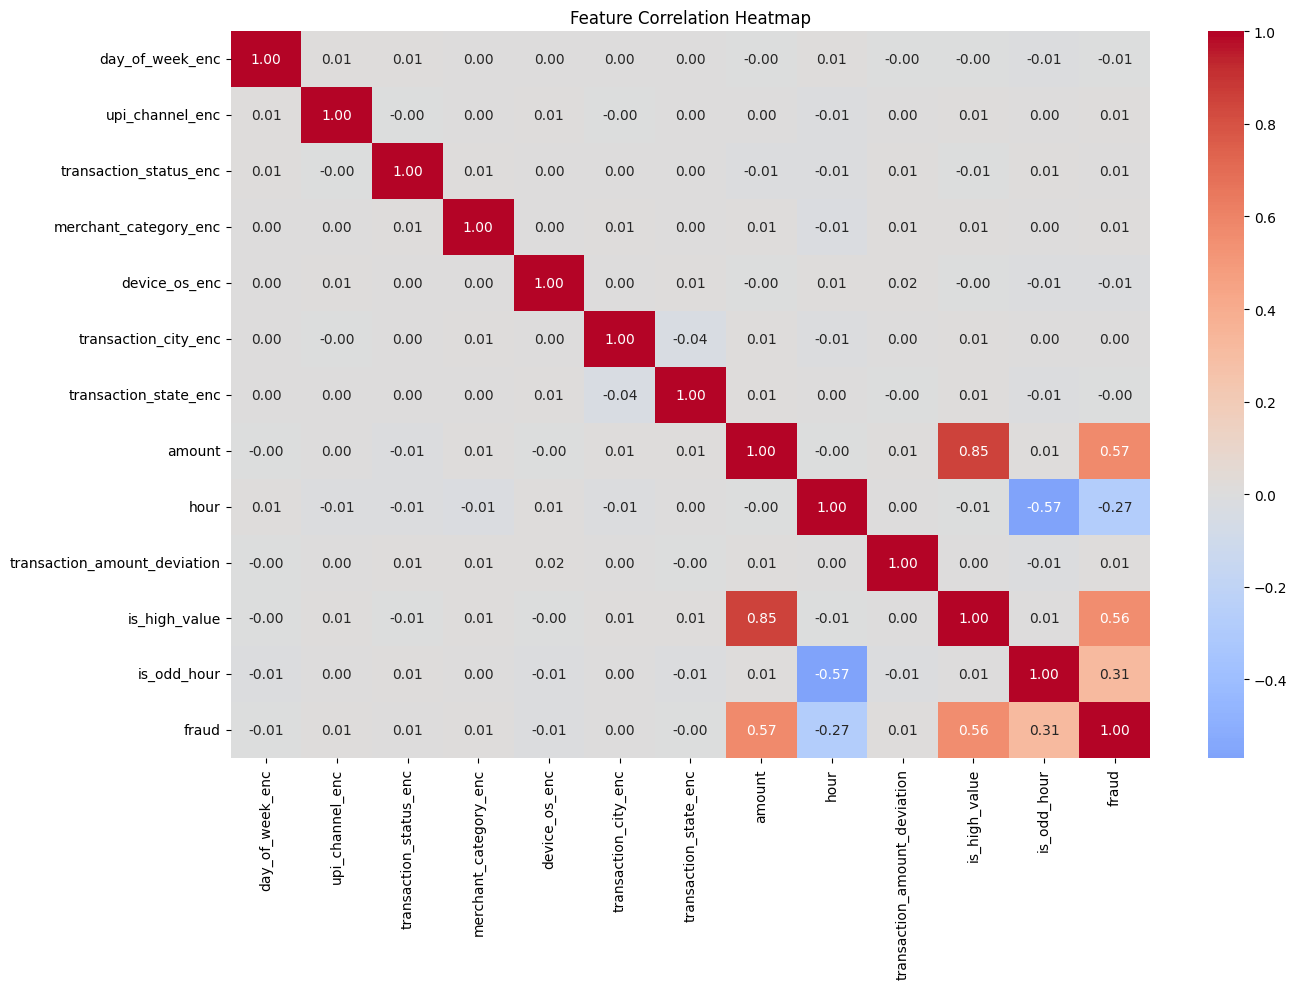

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for your features (including fraud)
corr = pdf[feature_cols + ['fraud']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [0]:
from sklearn.model_selection import train_test_split

# X = your features DataFrame
# y = your target variable (e.g., pdf['fraud'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,         # 20% for testing, 80% for training
    random_state=42,       # for reproducibility
    stratify=y             # keeps the fraud ratio similar in both sets
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (14000, 12) (14000,)
Test shape: (6000, 12) (6000,)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Initialize the Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    random_state=42,         # For reproducibility
    class_weight='balanced'  # Helps with class imbalance
)

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# 4. Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5374
           1       0.84      0.89      0.86       626

    accuracy                           0.97      6000
   macro avg       0.91      0.94      0.92      6000
weighted avg       0.97      0.97      0.97      6000

ROC AUC Score: 0.9932


In [0]:
import pickle

# Save the trained model to a file
with open('randomforest.pkl', 'wb') as file:
    pickle.dump(clf, file)

print("Model saved as randomforest.pkl")


Model saved as randomforest.pkl


In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


# Set scale_pos_weight to balance classes (optional, recommended for imbalanced data)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize and train XGBoost


model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5374
           1       0.82      0.94      0.87       626

    accuracy                           0.97      6000
   macro avg       0.90      0.96      0.93      6000
weighted avg       0.97      0.97      0.97      6000

ROC AUC Score: 0.9925407030180813


In [0]:
import pickle

# Save the trained model to a file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as xgb_model.pkl")


Model saved as xgb_model.pkl
